# Développement d'un modèle de prédiction de la durée de carrière de joueurs de NBA

Simon Bouaniche

Test MP DATA

<br>

### Objectif
L'objectif de ce notebook est de développer un modèle de classification binaire qui prédit si la carrière d'un jeune joueur de NBA va durer plus de 5 ans ou non. Le dataset d'entrainement est fourni par MP Data.

Une fois que le modèle sera développé, un autre scipt python permettra de le déployer sous forme d'une API REST via le framework FASTAPI

<br>

### Import modules


In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
import pickle
import warnings

### Exploration Dataset

In [2]:
df = pd.read_csv(".\\Test Data Science/nba_logreg.csv")
print(df.shape)
df

(1340, 21)


,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,...,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0.0
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,...,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0.0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,...,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0.0
3,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,...,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1.0
4,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,...,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1335,Chris Smith,80,15.8,4.3,1.6,3.6,43.3,0.0,0.2,14.3,...,1.5,79.2,0.4,0.8,1.2,2.5,0.6,0.2,0.8,0.0
1336,Brent Price,68,12.6,3.9,1.5,4.1,35.8,0.1,0.7,16.7,...,1.0,79.4,0.4,1.1,1.5,2.3,0.8,0.0,1.3,1.0
1337,Marlon Maxey,43,12.1,5.4,2.2,3.9,55.0,0.0,0.0,0.0,...,1.6,64.3,1.5,2.3,3.8,0.3,0.3,0.4,0.9,0.0
1338,Litterial Green,52,12.0,4.5,1.7,3.8,43.9,0.0,0.2,10.0,...,1.8,62.5,0.2,0.4,0.7,2.2,0.4,0.1,0.8,1.0


In [3]:
# visualisation globale très succinte et rapide pour détecter potentielles abérations
df.describe()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
count,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1329.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000
mean,60.414179,17.624627,6.801493,2.629104,5.885299,44.169403,0.247612,0.779179,19.308126,1.297687,1.821940,70.300299,1.009403,2.025746,3.034478,1.550522,0.618507,0.368582,1.193582,0.620149
std,17.433992,8.307964,4.357545,1.683555,3.593488,6.137679,0.383688,1.061847,16.022916,0.987246,1.322984,10.578479,0.777119,1.360008,2.057774,1.471169,0.409759,0.429049,0.722541,0.485531
min,11.000000,3.100000,0.700000,0.300000,0.800000,23.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.300000,0.000000,0.000000,0.000000,0.100000,0.000000
25%,47.000000,10.875000,3.700000,1.400000,3.300000,40.200000,0.000000,0.000000,0.000000,0.600000,0.900000,64.700000,0.400000,1.000000,1.500000,0.600000,0.300000,0.100000,0.700000,0.000000
50%,63.000000,16.100000,5.550000,2.100000,4.800000,44.100000,0.100000,0.300000,22.400000,1.000000,1.500000,71.250000,0.800000,1.700000,2.500000,1.100000,0.500000,0.200000,1.000000,1.000000
75%,77.000000,22.900000,8.800000,3.400000,7.500000,47.900000,0.400000,1.200000,32.500000,1.600000,2.300000,77.600000,1.400000,2.600000,4.000000,2.000000,0.800000,0.500000,1.500000,1.000000
max,82.000000,40.900000,28.200000,10.200000,19.800000,73.700000,2.300000,6.500000,100.000000,7.700000,10.200000,100.000000,5.300000,9.600000,13.900000,10.600000,2.500000,3.900000,4.400000,1.000000


#### Nans

In [4]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})

missing_value_df

# Nans dans les 3P% pour ceux qui ont zero 3P

,column_name,percent_missing
Name,Name,0.000000
GP,GP,0.000000
MIN,MIN,0.000000
PTS,PTS,0.000000
FGM,FGM,0.000000
FGA,FGA,0.000000
FG%,FG%,0.000000
3P Made,3P Made,0.000000
3PA,3PA,0.000000
3P%,3P%,0.820896


In [5]:
imputer = SimpleImputer(strategy="constant", fill_value=0)
df["3P%"] = imputer.fit_transform(df["3P%"].to_frame())
df["3P%"].astype("float64") #Imputer peut convertir float en objets


0       25.0
1       23.5
2       24.4
3       22.6
4        0.0
        ... 
1335    14.3
1336    16.7
1337     0.0
1338    10.0
1339    33.3
Name: 3P%, Length: 1340, dtype: float64

In [6]:
# Nans présents pour seule colonne "nombre de 3P marqués".
# On fixe à 0 cette valeur quand non présente.

imputer = SimpleImputer(strategy="constant", fill_value=0)
df["3P%"] = imputer.fit_transform(df["3P%"].to_frame())

df["3P%"].astype("float64") #Imputer peut convertir float en objets


percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df


,column_name,percent_missing
Name,Name,0.0
GP,GP,0.0
MIN,MIN,0.0
PTS,PTS,0.0
FGM,FGM,0.0
FGA,FGA,0.0
FG%,FG%,0.0
3P Made,3P Made,0.0
3PA,3PA,0.0
3P%,3P%,0.0


#### Box plot & distribution pour chaque variable

permet de détecter des outliers, ce qui servira dans le choix du scaler à utiliser (MinMax, Standard, Robust ...)

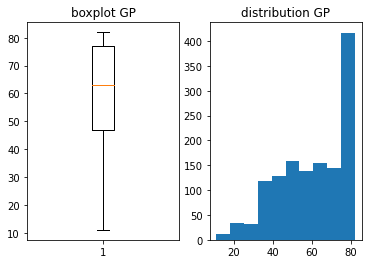

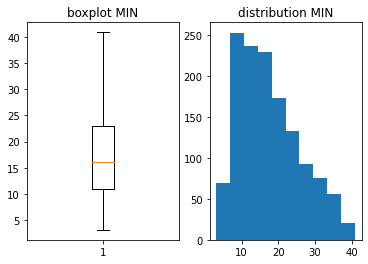

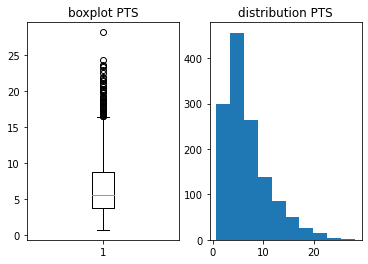

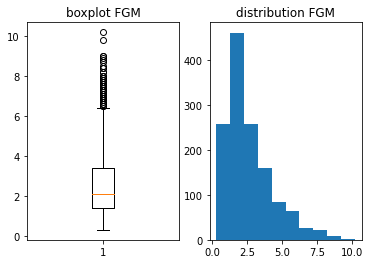

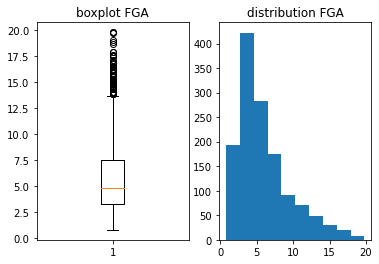

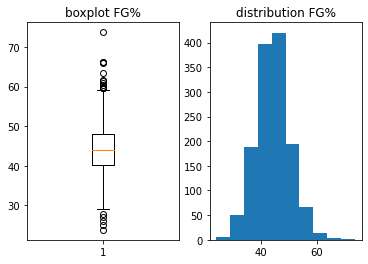

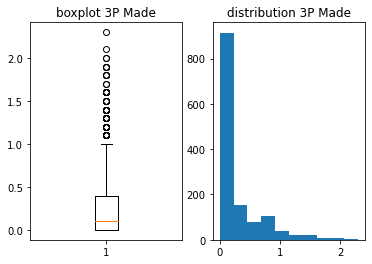

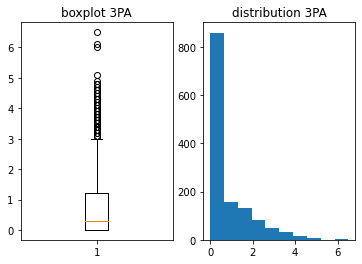

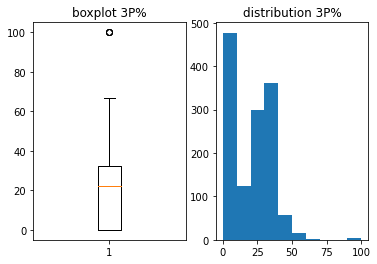

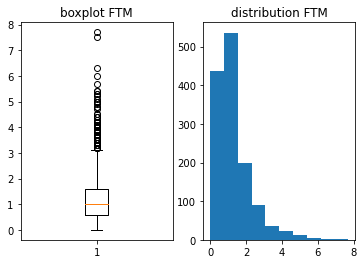

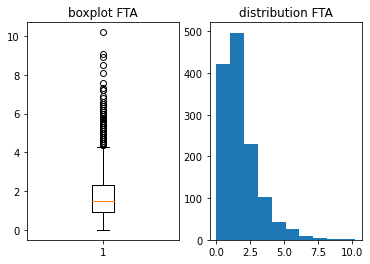

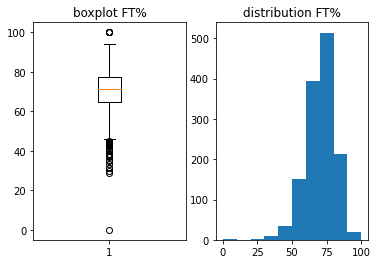

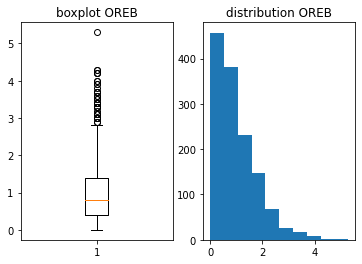

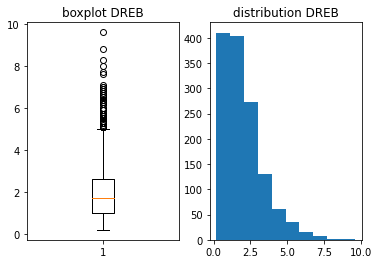

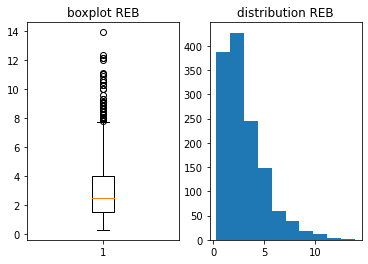

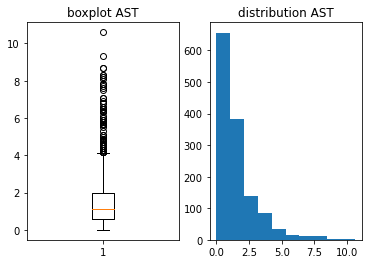

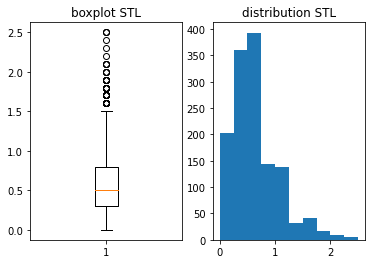

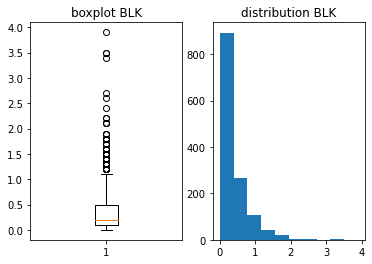

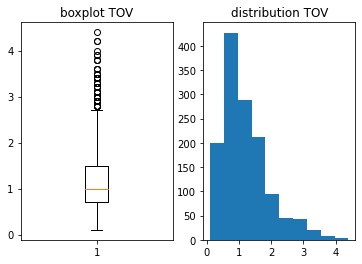

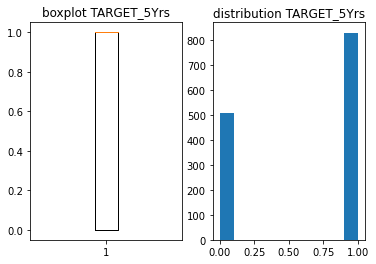

In [7]:
for column in df.select_dtypes(include=np.number).columns.to_list():
    plt.figure()
    plt.subplot(1,2,1)
    plt.boxplot(df[column])
    plt.title(f"boxplot {column}")

    plt.subplot(1,2,2)
    plt.hist(df[column])
    plt.title(f"distribution {column}")

plt.show()

distributions vraisemblables. Pas d'outliers détectés. Le scaler MinMax sera utilisé pour l'apprentissage

#### Equilibrage du dataset

Il faut vérifier que le dataset est équilibré (classes target 0 et 1 a peu près équivalentes en terme de population)

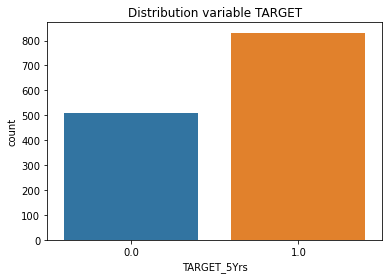

1.0    831
0.0    509
Name: TARGET_5Yrs, dtype: int64


In [8]:
import seaborn as sns
sns.countplot(x='TARGET_5Yrs', data=df)
plt.title("Distribution variable TARGET")
plt.show()
print(df["TARGET_5Yrs"].value_counts())

OK, classes à peu près équivalentes (dataset considéré déséquilibré quand une des classes représente moins de 25% de la population totale)

### Fonction de Scoring

Quelle métrique de scoring allons-nous utiliser pour déterminer les performances de notre modèle ? souhaitons-nous maximiser l'accuracy, la précision, le rappel, le f1 score ?

Afin de répondre à cette question il faut s'intéresser à notre objectif final.

Des investisseurs souhaitent connaître les futurs talents sur lesquels investir.
Tout est une question d'argent. Quel est le coût d'un joueur sur lequel on a investi, qui part tôt de la NBA (faux positif) ? quel est le coût d'un faux négatif, que rapporte un vrai positif ?

Cette question devrait en condition réelle être longuement étudiée. Est ce que le retour sur investissement 1:1 est atteint au bout de 5 ans ?

Dans le doute sur cette question, je préfère utiliser le F1 score, qui fait l'équilibre entre la précision et le rappel. De plus, il y a un très léger déséquilibre dans les classes (37% de négatifs seulement) ce qui penche en faveur de l'utilisation simultanée de la précision et du rappel.









### Préparation du dataset pour détermination du modèle

In [9]:
from sklearn.model_selection import train_test_split

X = df.drop(["TARGET_5Yrs", "Name"], axis = 1)
y = df["TARGET_5Yrs"]
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=4, shuffle=True)

scaler = MinMaxScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
# enregistrement du scaler
pickle.dump(scaler, open("scaler_MinMax", "wb"))

### F1 score Algortihme Naïf

#### Dummy classifier

 Nous savons qu'un modèle qui prédit toujours la même classe majoritaire, possède un f1 score maximum de 2*p / (p+1), où p est la proportion de positifs dans notre échantillon. Ici cette valeur vaut 0.78.


**Vérification**

In [10]:
p = y_test.value_counts()[1] / y_test.count()
2*p / (p+1)

0.7818181818181819

In [11]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
naivemodel = DummyClassifier()
naivemodel.fit(X_train, y_train)
f1_score(y_test, naivemodel.predict(X_test))

0.7818181818181819

#### Naive bayes classifier
estimation avec un autre algorithme naif

In [49]:
from sklearn.naive_bayes import GaussianNB

model_naive_bayes = GaussianNB()

model_naive_bayes.fit(X_train, y_train)

f1_score(y_test, model_naive_bayes.predict(X_test))

0.6610169491525425

Le score du naive bayes classifier est bien mons bon que le dummy classifier. Cela peut etre du a la grande corrélation (dépendance) des variables entre elles. En effet l'utilisation du naive bayes classifier présuppose l'indépendance des variables entre elles.

In [50]:
model_naive_bayes.predict(X_test)

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1,

### Régression logistique

Recherche des meilleurs paramètres d'une régression logistique à l'aide d'un grid search



In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import warnings
warnings.filterwarnings("ignore")
#warnings.filterwarnings("default")

parameters = { "C" : np.logspace(-4,4,30)}

stratified_kfold = StratifiedKFold(n_splits=4,
                                   shuffle=True,
                                   random_state=27)

grid_search_logreg = GridSearchCV(estimator=LogisticRegression(),
                                 param_grid=parameters,
                                 scoring="f1",
                                 cv=stratified_kfold,
                                 n_jobs=1,
                                 verbose = 3)

grid_search_logreg.fit(X_train, y_train)

Fitting 4 folds for each of 30 candidates, totalling 120 fits
[CV 1/4] END ..........................C=0.0001;, score=0.759 total time=   0.0s
[CV 2/4] END ..........................C=0.0001;, score=0.760 total time=   0.0s
[CV 3/4] END ..........................C=0.0001;, score=0.760 total time=   0.0s
[CV 4/4] END ..........................C=0.0001;, score=0.760 total time=   0.0s
[CV 1/4] END ..........C=0.00018873918221350977;, score=0.759 total time=   0.0s
[CV 2/4] END ..........C=0.00018873918221350977;, score=0.760 total time=   0.0s
[CV 3/4] END ..........C=0.00018873918221350977;, score=0.760 total time=   0.0s
[CV 4/4] END ..........C=0.00018873918221350977;, score=0.760 total time=   0.0s
[CV 1/4] END ...........C=0.0003562247890262444;, score=0.759 total time=   0.0s
[CV 2/4] END ...........C=0.0003562247890262444;, score=0.760 total time=   0.0s
[CV 3/4] END ...........C=0.0003562247890262444;, score=0.760 total time=   0.0s
[CV 4/4] END ...........C=0.0003562247890262444

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=27, shuffle=True),
             estimator=LogisticRegression(), n_jobs=1,
             param_grid={'C': array([1.00000000e-04, 1.88739182e-04, 3.56224789e-04, 6.72335754e-04,
       1.26896100e-03, 2.39502662e-03, 4.52035366e-03, 8.53167852e-03,
       1.61026203e-02, 3.03919538e-02, 5.73615251e-02, 1.08263673e-01,
       2.04335972e-01, 3.85662042e-01, 7.27895384e-01, 1.37382380e+00,
       2.59294380e+00, 4.89390092e+00, 9.23670857e+00, 1.74332882e+01,
       3.29034456e+01, 6.21016942e+01, 1.17210230e+02, 2.21221629e+02,
       4.17531894e+02, 7.88046282e+02, 1.48735211e+03, 2.80721620e+03,
       5.29831691e+03, 1.00000000e+04])},
             scoring='f1', verbose=3)

In [13]:
grid_search_logreg.best_estimator_

LogisticRegression(C=1.3738237958832638)

In [14]:
from sklearn.metrics import f1_score
f1_score(y_test,grid_search_logreg.best_estimator_.predict(X_test))

0.7955555555555556

Meilleur score de 0.79, obtenu pour C = 1.3. Il n'est pas nécéssaire d'effectuer une grille plus précise car les paramètres C proches aboutissent à des scores très proches, la grille était déjà assez fine.

### Random Forest Classifier

In [15]:
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings("ignore")
#warnings.filterwarnings("default")

parameters = { "n_estimators" : [50,100,200,500],
               'max_features': ['auto', 'sqrt', 'log2'],
               'max_depth' : [4,5,6,7,8],
               'criterion' :['gini', 'entropy']
               }

stratified_kfold = StratifiedKFold(n_splits=4,
                                   shuffle=True,
                                   random_state=27)

grid_search_rfc = GridSearchCV(estimator=RandomForestClassifier(),
                                  param_grid=parameters,
                                  scoring="f1",
                                  cv=stratified_kfold,
                                  n_jobs=1,
                                  verbose = 3)

grid_search_rfc.fit(X_train, y_train)

Fitting 4 folds for each of 120 candidates, totalling 480 fits
[CV 1/4] END criterion=gini, max_depth=4, max_features=auto, n_estimators=50;, score=0.747 total time=   0.1s
[CV 2/4] END criterion=gini, max_depth=4, max_features=auto, n_estimators=50;, score=0.788 total time=   0.1s
[CV 3/4] END criterion=gini, max_depth=4, max_features=auto, n_estimators=50;, score=0.768 total time=   0.0s
[CV 4/4] END criterion=gini, max_depth=4, max_features=auto, n_estimators=50;, score=0.765 total time=   0.1s
[CV 1/4] END criterion=gini, max_depth=4, max_features=auto, n_estimators=100;, score=0.742 total time=   0.2s
[CV 2/4] END criterion=gini, max_depth=4, max_features=auto, n_estimators=100;, score=0.768 total time=   0.2s
[CV 3/4] END criterion=gini, max_depth=4, max_features=auto, n_estimators=100;, score=0.755 total time=   0.2s
[CV 4/4] END criterion=gini, max_depth=4, max_features=auto, n_estimators=100;, score=0.751 total time=   0.2s
[CV 1/4] END criterion=gini, max_depth=4, max_feature

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=27, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [50, 100, 200, 500]},
             scoring='f1', verbose=3)

In [16]:
grid_search_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'max_features': 'auto',
 'n_estimators': 100}

In [17]:
f1_score(y_test,grid_search_rfc.best_estimator_.predict(X_test))

0.7826086956521738

### Gradient Boosting Classifier

In [41]:
from sklearn.ensemble import GradientBoostingClassifier

warnings.filterwarnings("ignore")
#warnings.filterwarnings("default")

parameters = {

    'learning_rate': [0.01,0.05,0.1,0.2,0.5,1],
    'max_depth': [2,3,4,5,6],
    'min_samples_leaf': [2,3,4,5,6],
    'n_estimators': [25,50,100,200],
    "tol" : np.logspace(-4,-1,4)
}

stratified_kfold = StratifiedKFold(n_splits=3,
                                   shuffle=True,
                                   random_state=27)

grid_search_gbc = GridSearchCV(estimator=GradientBoostingClassifier(),
                               param_grid=parameters,
                               scoring="f1",
                               cv=stratified_kfold,
                               n_jobs=1,
                               verbose = 0)

grid_search_gbc.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=27, shuffle=True),
             estimator=GradientBoostingClassifier(), n_jobs=1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5, 1],
                         'max_depth': [2, 3, 4, 5, 6],
                         'min_samples_leaf': [2, 3, 4, 5, 6],
                         'n_estimators': [25, 50, 100, 200],
                         'tol': array([0.0001, 0.001 , 0.01  , 0.1   ])},
             scoring='f1')

In [42]:
grid_search_gbc.best_params_

{'learning_rate': 0.01,
 'max_depth': 2,
 'min_samples_leaf': 2,
 'n_estimators': 100,
 'tol': 0.0001}

In [43]:
f1_score(y_test,grid_search_gbc.best_estimator_.predict(X_test))

0.7863247863247864

### SVC

In [21]:
from sklearn.svm import SVC

warnings.filterwarnings("ignore")
#warnings.filterwarnings("default")

parameters = {'C':[1,10,100,1000],
              'gamma':[1,0.1,0.001,0.0001],
              'kernel':['linear','rbf']}

stratified_kfold = StratifiedKFold(n_splits=4,
                                   shuffle=True,
                                   random_state=27)

grid_search_svc = GridSearchCV(estimator=SVC(),
                               param_grid=parameters,
                               scoring="f1",
                               cv=stratified_kfold,
                               n_jobs=1,
                               verbose = 3)

grid_search_svc.fit(X_train, y_train)

Fitting 4 folds for each of 32 candidates, totalling 128 fits
[CV 1/4] END .......C=1, gamma=1, kernel=linear;, score=0.735 total time=   0.0s
[CV 2/4] END .......C=1, gamma=1, kernel=linear;, score=0.784 total time=   0.0s
[CV 3/4] END .......C=1, gamma=1, kernel=linear;, score=0.764 total time=   0.0s
[CV 4/4] END .......C=1, gamma=1, kernel=linear;, score=0.797 total time=   0.0s
[CV 1/4] END ..........C=1, gamma=1, kernel=rbf;, score=0.753 total time=   0.0s
[CV 2/4] END ..........C=1, gamma=1, kernel=rbf;, score=0.786 total time=   0.0s
[CV 3/4] END ..........C=1, gamma=1, kernel=rbf;, score=0.770 total time=   0.0s
[CV 4/4] END ..........C=1, gamma=1, kernel=rbf;, score=0.788 total time=   0.0s
[CV 1/4] END .....C=1, gamma=0.1, kernel=linear;, score=0.735 total time=   0.0s
[CV 2/4] END .....C=1, gamma=0.1, kernel=linear;, score=0.784 total time=   0.0s
[CV 3/4] END .....C=1, gamma=0.1, kernel=linear;, score=0.764 total time=   0.0s
[CV 4/4] END .....C=1, gamma=0.1, kernel=linear

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=27, shuffle=True),
             estimator=SVC(), n_jobs=1,
             param_grid={'C': [1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.001, 0.0001],
                         'kernel': ['linear', 'rbf']},
             scoring='f1', verbose=3)

In [22]:
grid_search_svc.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

In [23]:
f1_score(y_test,grid_search_svc.best_estimator_.predict(X_test))

0.7857142857142857

Jusqu'ici, le modèle offrant les meilleures performances est la régression logistique (C = 1,4), pour un f1 score de 0.79.

Ce score est très proche du modèle dummy classifier. Nos algorithmes de machine learning ont peu d'intérêt

Cela semble a priori étonnant qu'une simple régression logistique aie de meilleures performances que des algorithmes généralement meilleurs comme Gradient Boosting. Cherchons des pistes d'explications.

Cela peut être du à la faible quantité de données (1300 échantillons). En effet, les algorithmes fonctionnant sur la base de l'agglomération de pleins d'estimateurs simples (RFC, GB) ont besoin de beaucoup de données.

Vérifions cela en affichant les courbes d'apprentissage (learning curve)

#### Courbes d'apprentissage
<br>

##### fonction tracé de learning curve


In [66]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, X, y, scoring, verbose):
    """
    fonction d'affichage de la learning curve
    """
    N, train_score, val_score = learning_curve(model, X, y, train_sizes=np.linspace(0.1,1,20), scoring = scoring, verbose = verbose)

    plt.plot(N, train_score.mean(axis=1), label = 'train')
    plt.plot(N, val_score.mean(axis=1), label = 'validation')

    plt.xlabel("train sizes")
    plt.title ("learning curve of " + f"{model}")
    plt.legend()
    plt.show()

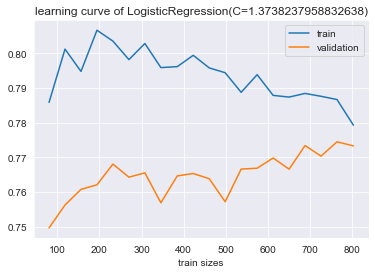

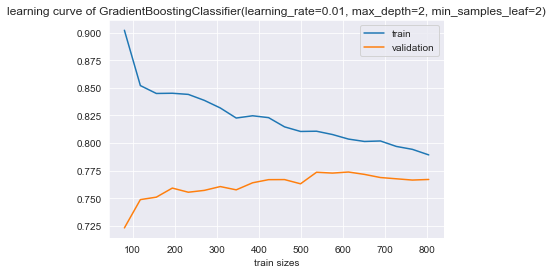

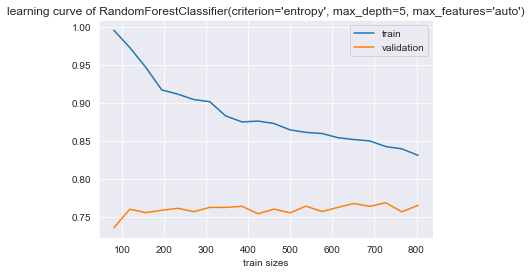

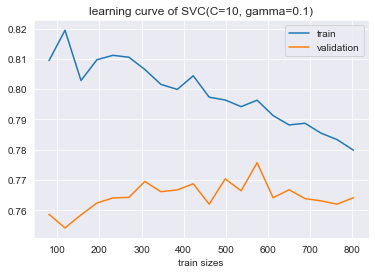

In [67]:
plot_learning_curve(grid_search_logreg.best_estimator_, X_train, y_train, scoring = "f1", verbose = 0)
plot_learning_curve(grid_search_gbc.best_estimator_, X_train, y_train, scoring = "f1", verbose = 0)
plot_learning_curve(grid_search_rfc.best_estimator_, X_train, y_train, scoring = "f1", verbose = 0)
plot_learning_curve(grid_search_svc.best_estimator_, X_train, y_train, scoring = "f1", verbose = 0)

Régression logistique : Amélioration possible avec l'ajout de données (courbe d'apprentissage n'a pas atteint d'asymptote horizontale)

modèle RFC : sur-apprentssage important

Utiliser des algorithmes de data augmentation serait pertinent.
Etant donné que la quantité de données est ici critique, contrairement à ce que j'ai annoncé plus haut, je vais ajouter des données dans la classe minoritaire (classe 0) pour l'équilibrer et ainsi augmenter le nombre de données, et voir si cela améliore les performances. (attention au data leakage : utilisation de pipeline)

Je vais uniquement garder les best estimators de la régression logistique et du gradient boosting classifier pour la suite. (les 2 modèles les plus performants)


#### SMOTE

In [69]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy=1.0) # La quantité finale de classe 0 = la quantité finale de classe 1


# définition pipeline log reg
pipe_logreg = Pipeline(steps = [("smote", smote),
                                ("model_logreg", grid_search_logreg.best_estimator_ )
                                ]
                       )
#définition pipeline gradient boosting classifier
pipe_gbc = Pipeline(steps = [("smote", smote),
                                ("model_logreg", grid_search_gbc.best_estimator_)
                                ]
                       )


pipe_logreg.fit(X_train,y_train)
pipe_gbc.fit(X_train,y_train)

score_logreg_augmented = f1_score(y_test, pipe_logreg.predict(X_test))
score_gbc_augmented = f1_score(y_test, pipe_gbc.predict(X_test))

print ("pipeline log reg score : ", score_logreg_augmented)
print ("pipeline gbc score : ", score_gbc_augmented)


pipeline log reg score :  0.7368421052631579
pipeline gbc score :  0.7153652392947105


**Conclusion** : Le fait d'avoir ajouté des données dans la classe minoritaire via SMOTE  a diminué les performances du modèle. pas la bonne voie. cela a probablement biaisé dans le mauvais sens le jeu de données.

**Autres pistes d'améliorations**  : Feature engineering ? quelles variables moduler ? Feature selection ?

Pour la suite je ne chercherai à améliorer que le modèle Logistic Regression


In [70]:
# Enregistrement du modèle final dans un fichier pickle

modele_final = grid_search_logreg.best_estimator_
pickle.dump(modele_final, open("model", "wb"))

In [71]:
model_final_reload = pickle.load(open("model", "rb"))

### Feature Selection

Il est possible que certaines des variables fournies ne soient pas utiles et dégradent les performances du modèle de machine learning. Afin de voir si je peux supprimer des variables pour améeliorer le score, ja vais utiliser la fonction RFECV (Recursive feature elimination by cross validation) de sklearn

In [72]:
from sklearn.feature_selection import RFECV
warnings.filterwarnings("ignore")
min_features_to_select=3
selector = RFECV(model_final_reload,
                 step = 1,
                 min_features_to_select = min_features_to_select,
                 scoring="f1",
                 cv = 3,
                 verbose = 2)

selector.fit(X  ,  y.to_numpy().reshape(len(y),))

Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.


RFECV(cv=3, estimator=LogisticRegression(C=1.3738237958832638),
      min_features_to_select=3, scoring='f1', verbose=2)

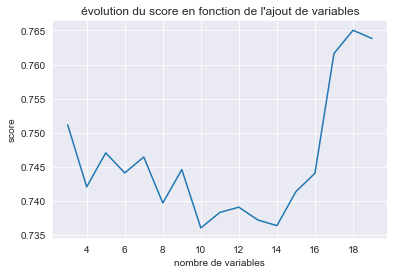

In [73]:
plt.plot(np.arange(3,20), selector.grid_scores_.mean(axis=1))
plt.title("évolution du score en fonction de l'ajout de variables")
plt.xlabel('nombre de variables')
plt.ylabel('score')
plt.show()

On a un maximum du score f1 pour 18 variables utilisées. Il y a un bond clair aux alentours de 15 variables. Je décide donc de garder l'ensemble des variables du dataset. Pour des questions d'explicabilité je décide d'afficher le classement général des features par importance

In [74]:
pd.DataFrame({"Feature": X.columns.to_list(), "Coef" : model_final_reload.coef_.tolist()[0]}).sort_values(by = "Coef", ascending = False)

,Feature,Coef
12,OREB,2.243209
0,GP,2.043636
17,BLK,1.280221
4,FGA,1.020591
15,AST,0.998630
5,FG%,0.812829
11,FT%,0.766142
3,FGM,0.741021
6,3P Made,0.703012
2,PTS,0.598859


Variable la plus importante : Games played

Il semble contradictoire qu'en parallèle, la variable "Minutes played" a un coefficient négatif : pousse le score vers 0.

La plupart des variables ont un coefficient positif comme on s'y attend : plus celles ci sont importantes et plus le joueur a un impact dans les parties donc a priori influe positivement le score.

Les variables ayant le coefficient le plus négatif sont "Defensive rebonds" et "Turnovers". Cela peut trouver son explication : Plus de DR et de TOV implique plus de défense en général. Or une equipe qui défend plus qu'elle n'attaque est peut - être plus susceptible de perdre la partie faute de marquer.







### Conclusion

Je ne pousserai pas plus loin la recherche du meilleur modèle, bien que le f1 score ne soit pas encore satisfaisant au vu de la proximité avec le modèle Dummy classifier.

En plus de faible quantité de données, cela peut être du à la corrélation importante entre les variables, et donc la nécéssité de feature engineering. J'espère pouvoir échanger avec les ingénieurs de MP DATA plus expérimentés afin d'éclaircir ce problème. Je procède maintenant au déploiement du modèle via FASTAPI


Pour effectuer des requêtes sur des nouveaux joueurs, il faudra fournir toutes les données répertoriées dans le dataset, et donc remplir 19 nombres sur le nouveau joueur